In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torchvision

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
max_epochs = 150
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.scripts.detection.coco_utils import get_coco
from pathlib import Path

COCO_ROOT = Path(DATA_ROOT).expanduser() / "coco"
is_train = False
image_set = "train" if is_train else "val"
num_classes, mode = {"coco": (91, "instances"), "coco_kp": (2, "person_keypoints")}["coco"]
with_masks = True
ds = get_coco(
    root=COCO_ROOT,
    image_set=image_set,
    transforms=None,
    mode=mode,
    use_v2=False,
    with_masks=with_masks,
)
data_idx = 6

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


## Original Data

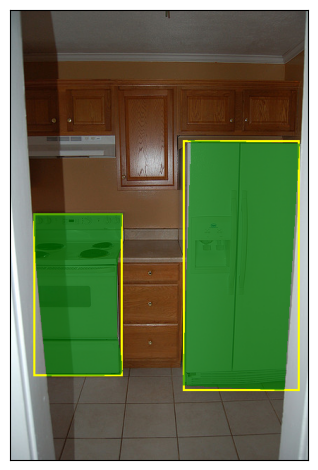

In [5]:
from hdd.visualization.vis_utils import det_seg_plot
original_image, original_target = ds[data_idx]
det_seg_plot([(original_image,original_target)])

## RandomHorizontalFlip

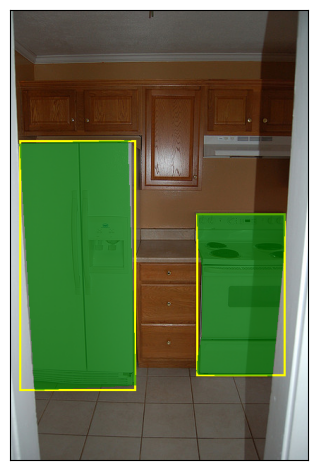

In [6]:
import hdd.scripts.detection.transforms as T

random_flip = T.RandomHorizontalFlip(0.9)
image, target = ds[data_idx]
hflip_image, hflip_target = random_flip(image, target)
det_seg_plot([(hflip_image,hflip_target)])

## RandomIoUCrop

In [8]:
random_iou_crop = T.RandomIoUCrop(0.9)
image, target = ds[data_idx]
iou_crop_image, iou_crop_target = random_iou_crop(image, target)


ValueError: The image and the masks must have the same height and width

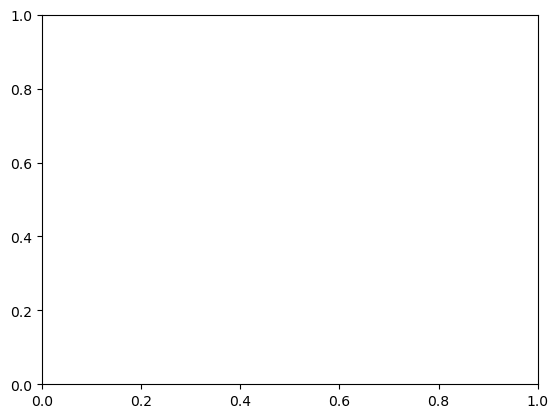

In [9]:
det_seg_plot([(iou_crop_image,iou_crop_target)])